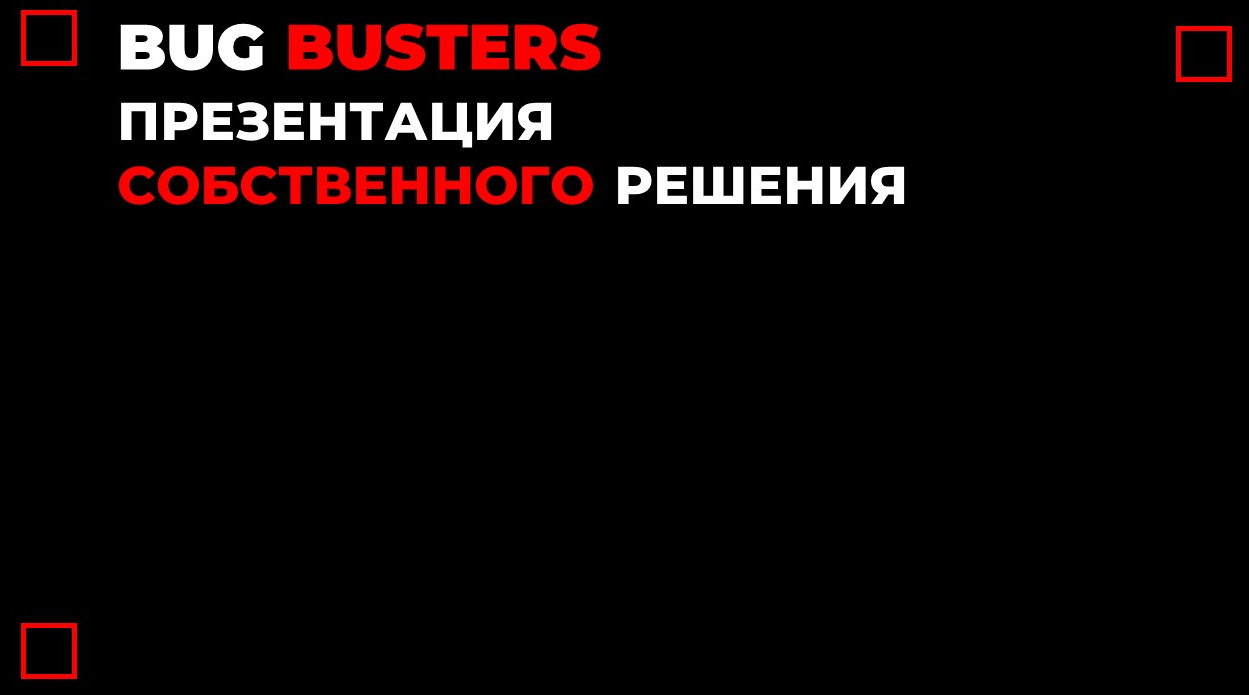

### Импорт библиотек и начальных данных

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy import interpolate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model, preprocessing, metrics
from sklearn.manifold import TSNE
from scipy. stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [101]:
df = pd.read_csv("test_well.csv", )
df.head()

,DT_HOUR,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
0,2021-03-21 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,0,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,0.0,37.17,29.5,29.4,29.6,396.0,399.0,399.0,NaN,71.0
3,2021-03-21 00:20:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,0,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Задание 0. Обработка данных

In [102]:
df = df.drop(["EXT_DATA", "PED_T", "U_OTP"], axis=1)
df["DT_HOUR"] = pd.to_datetime(df['DT_HOUR'], format='%Y-%m-%dT')
df["date"] = df['DT_HOUR'].apply(lambda x: x.strftime('%Y-%m-%d'))
df = df.groupby("date").agg("mean")
df = df.dropna(subset=['LIQ_RATE'])
df

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
date,,,,,,,,,,,,,,,
2021-03-21,388.84,42.61,87.46,17.755278,1853.77,40.0,68.041444,37.168472,29.459722,29.461111,29.552778,395.416667,398.861111,398.958333,71.000000
2021-03-22,390.57,42.59,88.04,17.674028,1809.27,40.0,68.106472,37.155556,29.462500,29.463889,29.563889,393.916667,399.166667,397.638889,71.000000
2021-03-23,395.10,42.47,87.95,17.800694,1822.53,40.0,68.024792,37.147778,29.445833,29.441667,29.537500,395.486111,400.666667,398.083333,71.000000
2021-03-24,389.34,42.54,88.02,17.786528,1855.33,40.0,68.118278,37.144306,29.451389,29.444444,29.534722,395.138889,400.083333,397.805556,71.000000
2021-03-25,391.28,42.55,88.22,17.830278,1827.74,40.0,68.120028,37.135000,29.454167,29.445833,29.550000,396.805556,399.916667,398.111111,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,435.36,47.78,88.12,17.784167,2247.43,43.0,83.571292,36.037500,32.233333,32.198611,32.381944,394.777778,398.430556,396.736111,73.000000
2021-06-17,455.25,49.96,88.43,17.896250,1416.76,43.0,83.633875,36.036111,32.219444,32.194444,32.362500,392.361111,396.583333,395.194444,73.000000
2021-06-18,433.74,47.62,88.32,17.996143,2166.77,43.0,83.449194,36.037361,32.212500,32.205556,32.355556,391.611111,396.388889,395.000000,73.000000


In [103]:
from sklearn.preprocessing import StandardScaler

In [104]:
cut_df = df.drop(columns=["OIL_RATE", "WATER_CUT", "PLIN", "QGAS", "FREQ_HZ"])
cut_df = cut_df.groupby("date").agg("mean")
cut_df = cut_df.dropna(subset=['LIQ_RATE'])
features = cut_df[cut_df.columns[1:]]
target = cut_df[cut_df.columns[0]]

In [105]:
scl = StandardScaler()
scl.fit(features)
X_scaled = scl.transform(features)

In [106]:
df.describe()

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,415.961667,45.495833,88.100076,17.879670,2159.574148,41.790516,77.478835,36.532672,31.129888,31.118256,31.252388,394.018587,398.235580,397.000430,72.372467
std,23.072456,2.627516,0.146838,0.116970,231.442014,1.143915,5.859576,0.364564,1.054277,1.050662,1.076267,2.524798,2.605853,2.533871,1.177375
min,290.546667,31.890000,87.460000,17.207324,1231.220000,40.000000,67.988385,36.035694,29.445833,29.441667,29.534722,384.541667,388.569444,387.430556,68.861111
25%,403.258750,43.996250,88.020000,17.829861,2059.902500,41.000000,72.972944,36.166736,30.356250,30.344271,30.456944,392.722222,397.055556,395.930556,71.052083
50%,405.677500,44.157500,88.110000,17.900486,2201.020000,41.000000,73.740473,36.687139,30.551389,30.536806,30.652083,394.513889,398.405419,397.307121,72.000000
75%,436.612500,47.888750,88.188750,17.948889,2287.607500,43.000000,83.566757,36.794514,32.240625,32.225000,32.389554,396.000000,400.122396,398.638889,73.027778
max,455.250000,49.960000,88.430000,18.056111,2572.670000,43.000000,83.748500,37.168472,32.277778,32.268056,32.420833,396.986111,402.388889,401.000000,74.000000


In [107]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Задание 1.

In [108]:
df['U_AB'].corr(df['LIQ_RATE'])

-0.20985541192408977

In [109]:
pearsonr(df['U_AB'], df['LIQ_RATE'])

(-0.2098554119240898, 0.04971813490285002)

In [110]:
X = df[["U_AB"]]
Y = df["LIQ_RATE"]

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [112]:
model = LinearRegression().fit(X_train, Y_train)
model.__dict__

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['U_AB'], dtype=object),
 'n_features_in_': 1,
 'coef_': array([-0.95074384]),
 '_residues': 34815.408408843585,
 'rank_': 1,
 'singular_': array([21.3867539]),
 'intercept_': 789.531180965245}

In [113]:
r_sq = model.score(X_train, Y_train)
slope = model.coef_
intercept = model.intercept_

In [114]:
print('coefficient of determination:', r_sq)
print('slope:', slope[0])
print('intercept:', intercept)

coefficient of determination: 0.011735951039768877
slope: -0.9507438417946013
intercept: 789.531180965245


In [115]:
Y_predicted = model.predict(X_test)

In [116]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predicted)))
print('R2 Score:', metrics.r2_score(Y_test, Y_predicted))
print("MAPE: ", metrics.mean_absolute_percentage_error(Y_test, Y_predicted))

Mean Absolute Error: 16.736242160103078
Mean Squared Error: 335.74627022370026
Root Mean Squared Error: 18.323380425666556
R2 Score: 0.08423371565665327
MAPE:  0.039671818807389694


### Задание 2. Отбор признаков и построение модели

In [134]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

<AxesSubplot:>

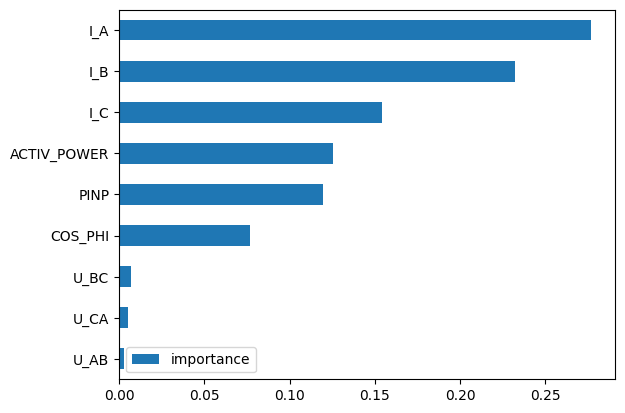

In [135]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
tmpdf1 = pd.DataFrame(columns = ['importance'], index=features.columns)
tmpdf1['importance'] = importances
tmpdf1.sort_values('importance').plot(kind='barh')

In [136]:
df_new = pd.read_csv("test_well.csv")
df_new.head()

,DT_HOUR,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
0,2021-03-21 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,0,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,0.0,37.17,29.5,29.4,29.6,396.0,399.0,399.0,NaN,71.0
3,2021-03-21 00:20:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,0,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
df_new = df_new.drop(["EXT_DATA", "PED_T", "U_OTP"], axis=1)
df_new["DT_HOUR"] = pd.to_datetime(df_new['DT_HOUR'], format='%Y-%m-%dT')
df_new["date"] = df_new['DT_HOUR'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_new = df_new.groupby("date").agg("mean")
df_new = df_new.dropna(subset=['LIQ_RATE'])

In [138]:
X = df_new[['I_A', 'I_C', 'I_B', 'COS_PHI', 'PINP', 'ACTIV_POWER', 'U_AB']]
Y = df_new[["LIQ_RATE"]]

In [139]:
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3)

In [144]:
GBR = GradientBoostingRegressor()

In [145]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500],
                  'max_depth'    : [4,6,8,10]
                 }

In [146]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

c:\pytorchtest\env\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10], 'n_estimators': [100, 500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [147]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.03, max_depth=8, subsample=0.1)

 The best score across ALL searched params:
 0.553639291599545

 The best parameters across ALL searched params:
 {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.1}


In [149]:
params = {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.1}
gbr = GradientBoostingRegressor(**params, random_state=42)
gbr.fit(X_train,y_train)

c:\pytorchtest\env\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.03, max_depth=8, random_state=42,
                          subsample=0.1)

In [182]:
### Предсказание
y_pred = gbr.predict(X_test)

### И среднеквадратичную ошибку
mse = metrics.mean_absolute_error(y_test,y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))
print("MAPE: ", metrics.mean_absolute_percentage_error(y_test, y_pred))

Mean Absolute Error: 4.387849754782009
Mean Squared Error: 44.791560832929946
Root Mean Squared Error: 6.692649761710973
R2 Score: 0.8554968833992874
MAPE:  0.010276306452682042


In [185]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [186]:
model = Sequential()
model.add(Dense(units = 256, activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

In [187]:
model.fit(X_train,y_train,epochs=1000,batch_size=32)
y_pred = model(X_test)

Epoch 1/1000
2/2 [==============================] - 0s 3ms/step - loss: 415.2389
Epoch 2/1000
2/2 [==============================] - 0s 4ms/step - loss: 414.8947
Epoch 3/1000
2/2 [==============================] - 0s 3ms/step - loss: 414.5816
Epoch 4/1000
2/2 [==============================] - 0s 3ms/step - loss: 414.2773
Epoch 5/1000
2/2 [==============================] - 0s 3ms/step - loss: 413.9719
Epoch 6/1000
2/2 [==============================] - 0s 3ms/step - loss: 413.6535
Epoch 7/1000
2/2 [==============================] - 0s 3ms/step - loss: 413.2983
Epoch 8/1000
2/2 [==============================] - 0s 4ms/step - loss: 412.9254
Epoch 9/1000
2/2 [==============================] - 0s 4ms/step - loss: 412.5086
Epoch 10/1000
2/2 [==============================] - 0s 4ms/step - loss: 412.0320
Epoch 11/1000
2/2 [==============================] - 0s 4ms/step - loss: 411.5065
Epoch 12/1000
2/2 [==============================] - 0s 4ms/step - loss: 410.9162
Epoch 13/1000
2/2 [======

In [188]:

mse = metrics.mean_absolute_error(y_test,y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('R2 Score:', metrics.r2_score(y_test,y_pred))
print("MAPE: ", metrics.mean_absolute_percentage_error(y_test,y_pred))

Mean Absolute Error: 3.46146502459491
Mean Squared Error: 41.188520393319365
Root Mean Squared Error: 6.41782832376493
R2 Score: 0.8671207376048626
MAPE:  0.008473526443743244
